<a href="https://colab.research.google.com/github/bitanb1999/Project_ML_1/blob/master/Projet_Yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATA ANALYSIS AND EDA REGARDING THE BUSINESS DATASET OF YELP:

In [1]:
#Import libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import sklearn.metrics
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#####The Business Dataset of Yelp has lots of businesses, their addresses, geospatial locations, categories, attributes and most importantly the Average ratings of these businesses.

In [2]:
business = []
with open('/content/drive/MyDrive/yelp_academic_dataset_business.json', 'rb') as f:
    for i, line in enumerate(f):
        business.append(json.loads(line))

business = pd.DataFrame(business)


In [3]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


Let's look at the rating distribution of this huge dataset:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


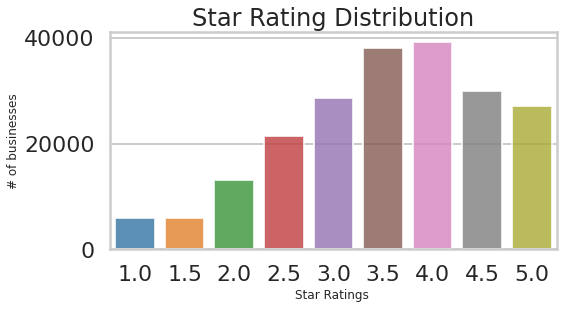

In [4]:
#Get the distribution of the ratings
x=business['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

plt.show();

####Finding the top 10 business categories and also the distribution of restaurants in different places: 

First we eliminate all the cases where the business has no categories.Then we get hold of the categories and plot to have a look at which category has a decent amount of holdings in the dataset.Based on a that result, we will get hold of that category and further progress with our data analysis

In [5]:
business= business[business['categories'].notna()]


In [6]:
import re
categ=';'.join(business['categories'])
cat=re.split(';|,', categ)
business_categories=pd.DataFrame([item.strip() for item in cat],columns=['category'])

In [7]:
businesscount=business_categories.category.value_counts().sort_values(ascending = False)[:10]
businesscount

Restaurants         63944
Shopping            34644
Food                32991
Home Services       22487
Beauty & Spas       20520
Health & Medical    19227
Local Services      15783
Automotive          14720
Nightlife           14211
Bars                12400
Name: category, dtype: int64

Since we are going to exclusively deal with the restaurants,we will take the subset of the cases where the business is just Restaurant type:

In [8]:
Restaurants = business.loc[[i for i in business['categories'].index if re.search('Restaurants', business['categories'][i])]]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


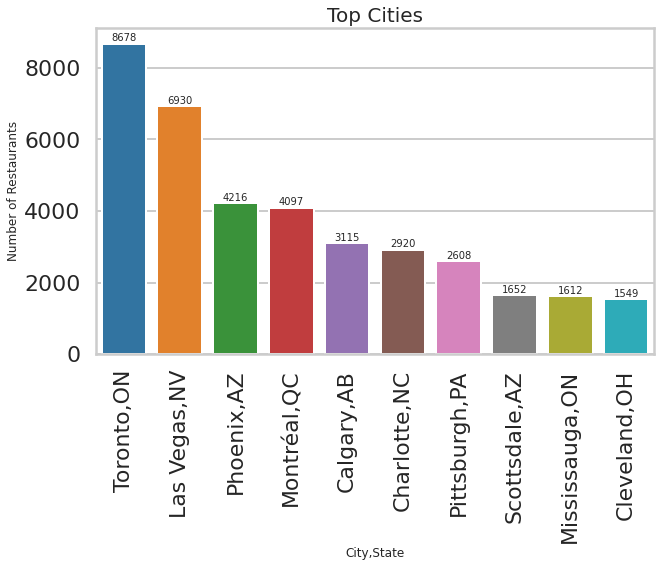

In [9]:
Restaurants['city_state'] = Restaurants['city'] + ',' + Restaurants['state']
city_count = Restaurants.city_state.value_counts().sort_values(ascending = False)[:10]

# plot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(city_count.index, city_count.values)
plt.title("Top Cities",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Number of Restaurants', fontsize = 12)
plt.xlabel('City,State', fontsize = 12)

#text labels
r = ax.patches
labels = city_count.values
for rect, label in zip(r, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

_We see that Toronto,Ontario has the highest number of restaurants, followed by Las Vegas,Phoenix City and the rest. The Toronto subset also has an error where the state is mispelled as OH instead of ON. We take care of that case as well._

Now considering Toronto has the highest number of Restaurants, we subset our restaurant navigation further to just Toronto.

In [10]:
toronto_df=Restaurants[Restaurants.city=='Toronto']
toronto_df=toronto_df.drop(['address','city','state','hours','city_state'],axis=1)
toronto_df=toronto_df[toronto_df.is_open==1]

In [11]:
toronto_df=toronto_df.drop('is_open',axis=1)


In [12]:
toronto_df.shape

(5462, 9)

Now, we notice that each business has multiple branches or outlets in Toronto, such as Tim Hortons has 58 instances with various ratings. This brings us to a plotting or analysis junction where we can which businesses have the highest number of outlets in Toronto.

In [13]:
toronto_df[toronto_df.name=='Tim Hortons'].shape

(58, 9)

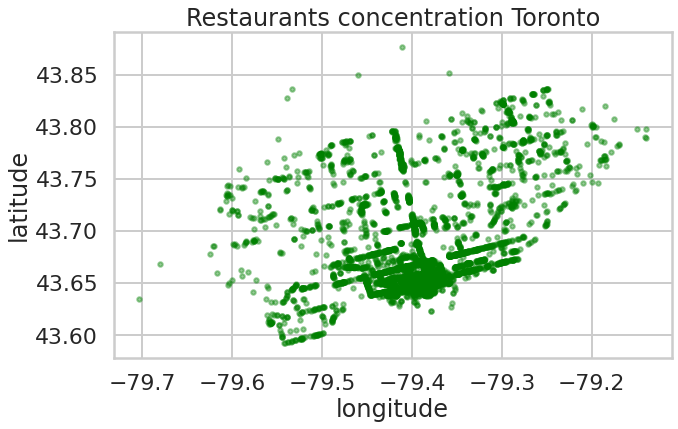

In [14]:
f, ax = plt.subplots(1, 1, figsize=(10,6))

#coordinates for Toronto
lat_t = 43.6532
lon_t = -79.3832

lon_t_min, lon_t_max = lon_t-0.5,lon_t+0.5
lat_t_min, lat_t_max = lat_t-0.5,lat_t+0.5

#subset the data
map_=toronto_df[(toronto_df["longitude"]>lon_t_min) & (toronto_df["longitude"]<lon_t_max) &\
                    (toronto_df["latitude"]>lat_t_min) & (toronto_df["latitude"]<lat_t_max)]

#plot
map_.plot(kind='scatter', x='longitude', y='latitude',
                color='green',alpha=0.4, ax=ax)
ax.grid('off')
ax.set_title("Restaurants concentration Toronto");




####Plotiing the top 20 restaurants of Toronto:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


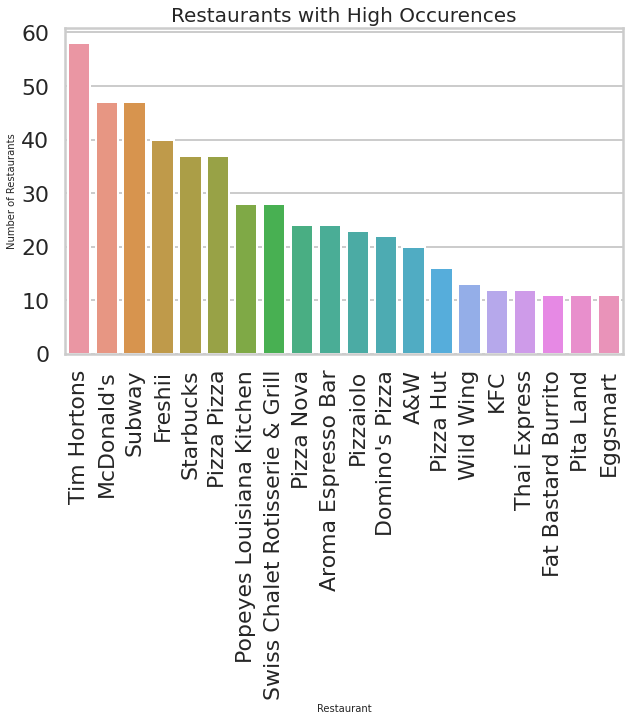

In [15]:
TopRes = toronto_df.name.value_counts().sort_values(ascending = False)[:20]

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(TopRes.index, TopRes.values)
plt.title("Restaurants with High Occurences",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Number of Restaurants', fontsize = 10)
plt.xlabel('Restaurant', fontsize = 10);

We see that Tim Hortons and Mc Donalds followed by Subway lead the graph with the highest number of occurences.These businesses seem to have opened lot of franchises/branches in the city. Although, it doesn't really mean that they have a strong positive response from the users in that aspect. We look into that as well in some of our EDA.

####Plotting the ratings obtained by Restaurants of the top 20 Restaurants:

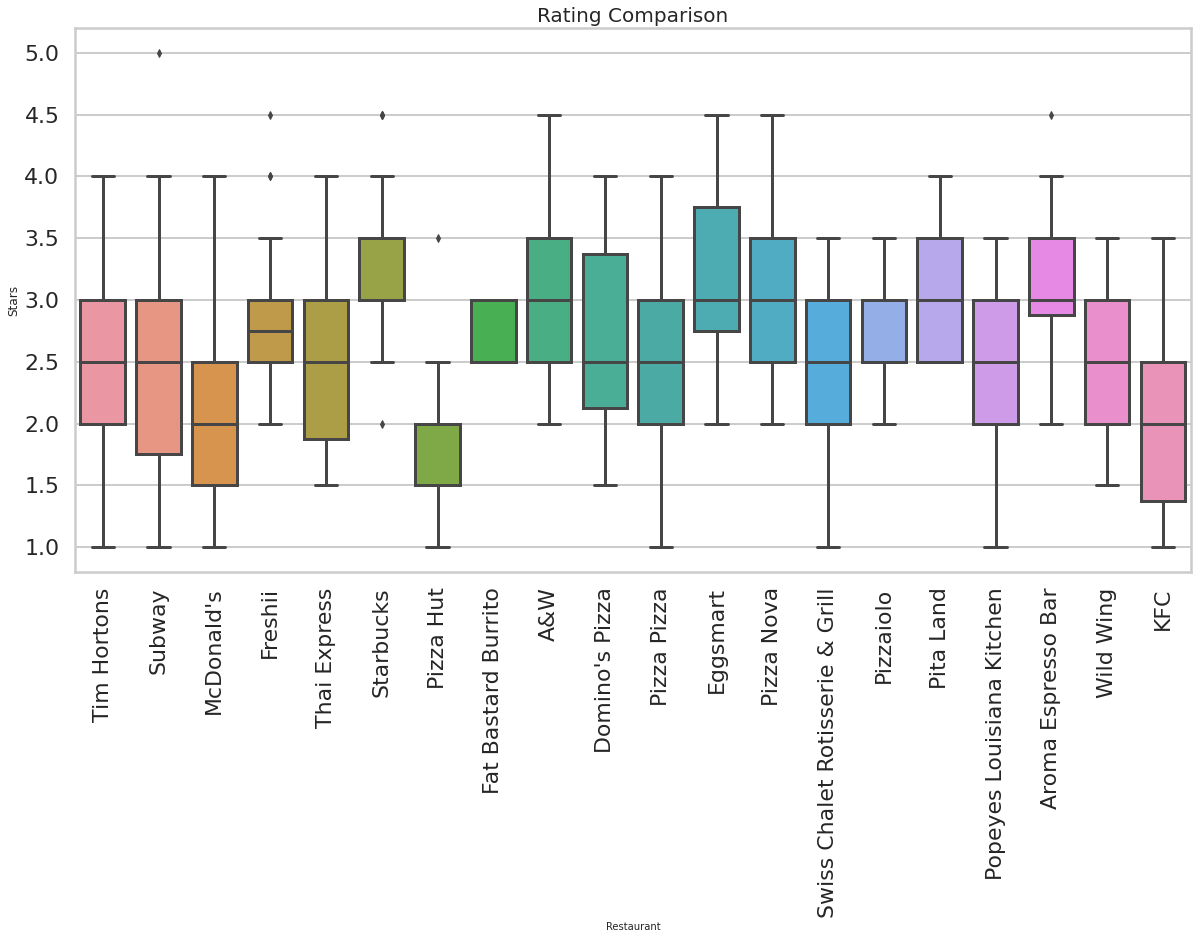

In [16]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(x = 'name', y = 'stars', data = toronto_df[toronto_df.name.isin(TopRes.index)])
plt.title("Rating Comparison",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('Restaurant', fontsize = 10);

This boxplot gets use the mean ratings and the range of ratings received by each of these restaurants. There are a certain number of outliers in case of a few restaurants and for most of them,the outliers are high rankings, which is a good thing!

In [17]:
TopRes.index

Index(['Tim Hortons', 'McDonald's', 'Subway', 'Freshii', 'Starbucks', 'Pizza Pizza', 'Popeyes Louisiana Kitchen', 'Swiss Chalet Rotisserie & Grill', 'Pizza Nova', 'Aroma Espresso Bar', 'Pizzaiolo', 'Domino's Pizza', 'A&W', 'Pizza Hut', 'Wild Wing', 'KFC', 'Thai Express', 'Fat Bastard Burrito', 'Pita Land', 'Eggsmart'], dtype='object')

Further there is a relation between the stars received by the restaurants and review counts:

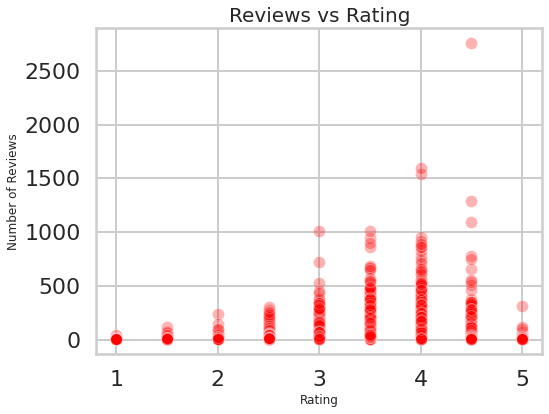

In [18]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'stars', y = 'review_count',color='red',alpha=0.3 ,data = toronto_df)
plt.title("Reviews vs Rating",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Rating', fontsize = 12);

We see that the review count is mostly concentrated in the lower regions. Most ratings are based on less number of reviews and quite a few have received a high rating where the review count is also high. we might look at these Restaurants once where the review count is more than 500 and the rating is above 3.5

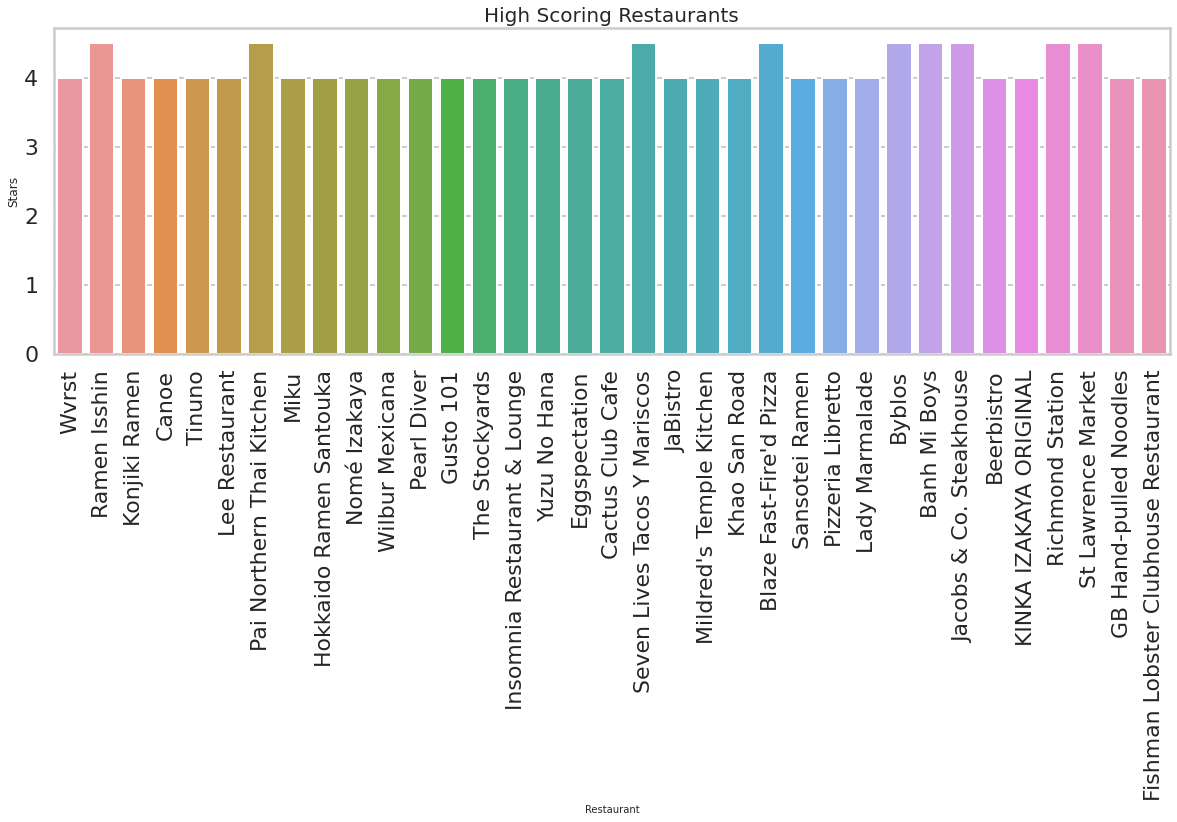

In [19]:
df=toronto_df[(toronto_df.stars>3.5) &(toronto_df.review_count>500)]
fig,ax=plt.subplots(figsize=(20,6))
sns.barplot(data=df,x=df.name,y=df.stars,ax=ax)
plt.title("High Scoring Restaurants",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('Restaurant', fontsize = 10);

These few restaurants have received a high rating as well as have a good number of reviews. This implies that not only do they have a strong user base but they also seem to be liked by the users.

######We flatten the attributes part of the dataset which holds dictionary of the various attributes of the businesses

In [20]:
toronto_df['attributes'] = toronto_df['attributes'].apply(lambda x: {} if x is None else x)
df = pd.json_normalize(toronto_df.attributes)

In [21]:
df


,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,Ambience,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService
0,True,u'beer_and_wine',True,1,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,False,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'no',True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,'none',True,1,'casual',False,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,False,NaN,NaN,'no',False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,'none',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,True,'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'no',True,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,NaN,NaN,1,NaN,NaN,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,True,NaN,NaN,u'free',True,NaN,NaN,False,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,u'full_bar',True,3,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': False, 'validated'...",True,True,False,u'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'free',True,True,True,False,NaN,NaN,NaN,"{'dj': False, 'background_music': False, 'no_m...",True,"{'monday': False, 'tuesday': False, 'friday': ...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,True,u'beer_and_wine',True,2,u'casual',True,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,True,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'free',True,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5458,True,u'none',True,2,u'casual',True,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': False, 'validated'...",True,False,False,'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'free',False,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5459,True,u'full_bar',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': True, 'validated':...",True,True,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'free',True,True,False,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5460,True,NaN,True,2,'casual',False,"{'romantic': False, 'intimate': False, 'classy...",NaN,True,False,False,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def atomicrows(df,target_column):

    def splitListToRows(row,row_accumulator,target_column):

        new_row = row.to_dict()
        
        try:
            split_row = row[target_column]['Ambience'].replace('\'', "").replace('{','').replace('}','').split(",")
        
            for i in split_row:

                if i is None:
                    
                    continue
                
                try:

                    new_row["amb_"+i.split(":")[0].strip()] = i.split(":")[1].replace('\'', "").strip()
                    
                except:

                    f = 0

        except:

            f = 1

        row_accumulator.append(new_row)

    new_rows = [] 
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column))
    new_df = pd.DataFrame(new_rows)
    return new_df


Using the atomic_rows function, we get hold of the dictionary inside the ambience key of the attributes dictionaries and flatten it in order to get hold of the different ambiences provided by the different restaurants

In [23]:
df2 = atomicrows(toronto_df,'attributes')

df2.shape

(5462, 18)

In [24]:
df2.to_pickle('toronto_restaurant')

In [120]:
restaurants = pd.read_pickle('toronto_restaurant')
restaurants=restaurants[restaurants.attributes.notnull()]

restaurants.shape

(5462, 18)

We have already flattened out the ambiences using the atomicrow function and now we flatten the attributes manually

In [131]:
res=pd.DataFrame()
for i in range(len(restaurants.attributes)):
  c=0
  d={}
  dict_=restaurants.iloc[i].attributes
  d['business_id']=restaurants.iloc[i]['business_id']
  d['name']=restaurants.iloc[i]['name']
  d['postal_code']=restaurants.iloc[i]['postal_code']
  d['latitude']=restaurants.iloc[i]['latitude']
  d['longitude']=restaurants.iloc[i]['longitude']
  d['stars']=restaurants.iloc[i]['stars']
  d['review_count']=restaurants.iloc[i]['review_count']
  d['categories']=restaurants.iloc[i]['categories']

  d['amb_romantic']= restaurants.iloc[i]['amb_romantic']
  d['amb_intimate']= restaurants.iloc[i]['amb_intimate']
  d['amb_classy']= restaurants.iloc[i]['amb_classy']
  d['amb_hipster']= restaurants.iloc[i]['amb_hipster']
  d['amb_divey']= restaurants.iloc[i]['amb_divey']
  d['amb_touristy']= restaurants.iloc[i]['amb_touristy']
  d['amb_trendy']= restaurants.iloc[i]['amb_trendy']
  d['amb_upscale']= restaurants.iloc[i]['amb_upscale']
  d['amb_casual']= restaurants.iloc[i]['amb_casual']

  for key,value in dict_.items():
    d[key]=value
  
  
  d=pd.DataFrame(d,columns=d.keys(),index=[i])
  res=pd.concat([res,d])

In [132]:
res

,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,Ambience,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",False,False,False,False,False,False,False,False,True,True,u'beer_and_wine',True,1,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,False,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'no',True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,False,False,False,NaN,False,False,False,False,True,'none',True,1,'casual',False,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,False,NaN,NaN,'no',False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",False,False,False,False,NaN,False,False,False,False,True,'none',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,True,'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'no',True,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,1,NaN,NaN,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,True,NaN,NaN,u'free',True,NaN,NaN,False,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",False,False,True,False,False,False,False,False,False,True,u'full_bar',True,3,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': False, 'validated'...",True,True,False,u'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'free',True,True,True,False,NaN,NaN,NaN,"{'dj': False, 'background_music': False, 'no_m...",True,"{'monday': False, 'tuesday': False, 'friday': ...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,thzyiQZb16zD8wMliaEfRQ,Sushi Supreme,M4S 1Z8,43.700617,-79.396762,4.0,104,"Sushi Bars, Restaurants, Japanese",False,False,False,False,False,False,False,False,True,True,u'beer_and_wine',True,2,u'casual',True,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,True,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'free',True,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5458,eUi3O-8Gqh_nJ_ZhO-25gQ,Get & Go Burrito,M3K 1G7,43.726656,-79.480365,3.5,43,"Mexican, Restaurants",False,False,False,False,False,False,False,False,Tr

We have flattened the attributes and now we handle the NaNs and impute certain values and handle the missing values accordingly

In [133]:
res['RestaurantsPriceRange2']=res['RestaurantsPriceRange2'].replace(np.nan,0)
res['RestaurantsAttire']=res['RestaurantsAttire'].replace(np.nan,"streets")
res['Alcohol']=res['Alcohol'].replace(np.nan,"u'none'")
res['Caters']=res['Caters'].replace(np.nan,"False")
for i in res.columns[13:]:
  res[i]=res[i].replace(np.nan,"False")
res['BusinessParking']=res['BusinessParking'].apply(lambda x:'True'if "True" in x else "False")

res['GoodForMeal']=res['GoodForMeal'].astype('category').cat.codes.values

In [134]:
for i in res.columns[9:]:
  res[i]=res[i].astype('category').cat.codes.values

In [137]:
res=res.drop('Ambience',axis=1)

In [138]:
#table report 
from IPython.display import display, HTML
def pretty_print(df):
    return display(HTML( df.to_html().replace('\\n', '<br>')))

def table_report(tbl, cols=None, card=20):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    #print(dtypes)
    nulls = []
    uniques = []
    numuniques = []
    vcs=[]
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card:
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join("{}:{}".format(k,v) for k, v in valcounts.items())
        else:
            vc = 'NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)
    

In [139]:
table_report(res)

Table Shape (5462, 53)


Now we try and flatten the category column in order to increase more number of latent Factors in our Data

In [31]:
df = pd.Series(res['categories']).str.get_dummies(',')


In [32]:
df.columns = df.columns.str.strip()

df.drop(['Food','Restaurants'],axis=1,inplace=True)

df.shape

(5462, 545)

In [33]:
ratings=pd.DataFrame(res[['stars','categories']],index=res.index,columns=['stars','categories'])
ratings=pd.merge(ratings,df,left_index=True,right_index=True)

In [34]:
ratings

,stars,categories,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Afghan,African,Alternative Medicine,American (New),American (Traditional),Amusement Parks,Antiques,Appliances,Arabian,Arcades,Argentine,Art Classes,Art Galleries,Art Schools,Arts & Crafts,Arts & Entertainment,Asian Fusion,Australian,Automotive,Bagels,Bakeries,Bangladeshi,Barbeque,Bars,Bartenders,Beauty & Spas,Beer,Beer Bar,Belgian,Bistros,Bocce Ball,Books,Bookstores,Bowling,Brasseries,Brazilian,Breakfast & Brunch,Breweries,Brewpubs,British,Bubble Tea,Buffets,Burgers,...,Pool Halls,Pop-Up Restaurants,Portuguese,Poutineries,Pubs,Ramen,Recreation Centers,Roofing,Salad,Sandwiches,Seafood,Seafood Markets,Shaved Ice,Shaved Snow,Shopping,Shopping Centers,Smokehouse,Social Clubs,Soul Food,Soup,Southern,Spanish,Speakeasies,Specialty Food,Sports Bars,Sri Lankan,Steakhouses,Street Vendors,Sushi Bars,Swiss Food,Syrian,Tacos,Taiwanese,Tapas Bars,Tapas/Small Plates,Tea Rooms,Tex-Mex,Thai,Themed Cafes,Turkish,Ukrainian,Vegan,Vegetarian,Vietnamese,Waffles,Whiskey Bars,Wine Bars,Wineries,Women's Clothing,Yelp Events
0,4.0,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,3.0,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.5,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.5,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,4.0,"Sushi Bars, Restaurants, Japanese",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5458,3.5,"Mexican, Restaurants",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5459,4.0,"Vegan, Restaurants, Vegetarian, Salad",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5460,4.0,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The ratings Dataset has 547 columns which, if added further to increase the number of latent factors for the businesses doesn't really help,as they are sparsely valued and might just add to more mis-specification without any improvement. Hence, we keep them notably, away from our business data, now the 'res' dataset.

Now we do some EDA on the categories obtained:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


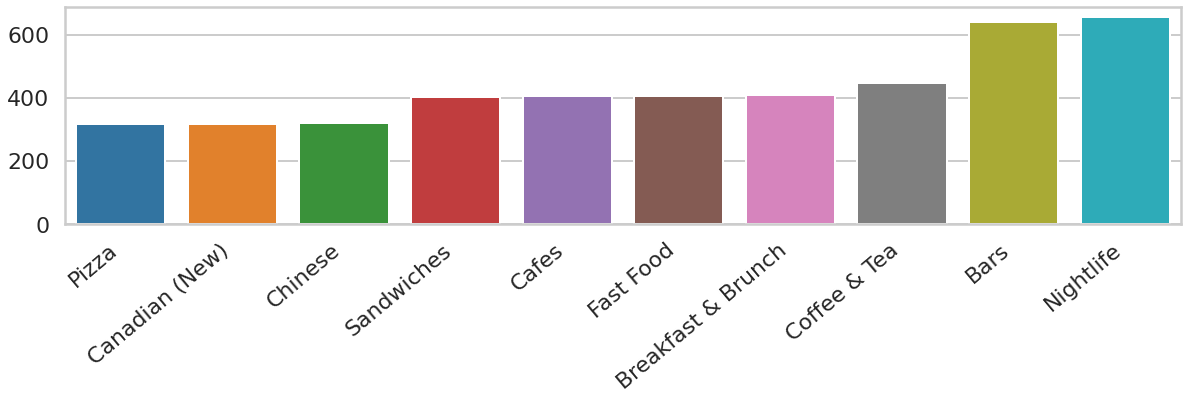

In [35]:
top_cats = df.sum().sort_values()[-10:]

plt.figure(figsize=(20,4))
ax = sns.barplot(top_cats.index,top_cats.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

The categories of Bar,NightLife and Coffee&Tea seem to have a strong hold on the market of Toronto. The Cafes,Fast Food, BreakFast and Brunch seem to be do more or less in the same range.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


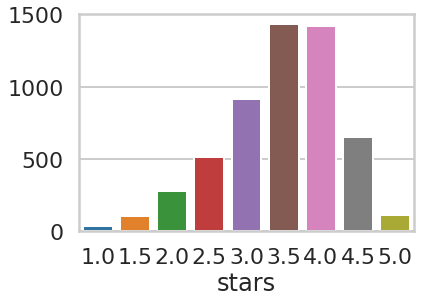

In [36]:
ratings = res.groupby('stars').count()['review_count']
sns.barplot(ratings.index,ratings.values)

Comparing the relations between the stars and review counts, we see most People or users have rated the businesses decently,implying that the restaurants of Toronto, seem to be doing well, in matters of response from the people.

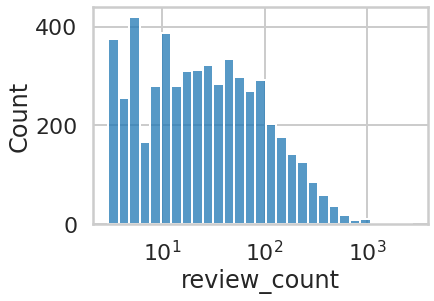

In [37]:
sns.histplot(res['review_count'],log_scale=True)

On plotting the review counts for different businesses, we see that most business ratings are based on poor number of reviews and hence, the ratings don't have a strong credibility in these cases.

##The Review Dataset:

In [38]:

import json 
def init_ds(json):
  ds={}
  keys = json.keys() 
  for k in keys:
     ds[k]= []
  return ds, keys 
def read_json(file): 
  dataset = {}
  keys = [] 
  with open(file) as file_lines:
    for count, line in enumerate(file_lines):
       data = json.loads(line.strip()) 
       if count ==0:
          dataset, keys = init_ds(data)
       for k in keys: 
         dataset[k].append(data[k]) 

    return pd.DataFrame(dataset)

In [39]:
reviews = read_json("drive/MyDrive/yelp_academic_dataset_review.json")

In [40]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [41]:
reviews=reviews.drop(['text','date'],axis=1)

We remove the date and text columns as reviews don't matter, as we already have the rating of that user for that particular restaurant.Also, the date of the review doesn't really concern us.

In [42]:
#reviews=reviews.drop('review_id',axis=1)

Creating a new Column 'response' which gets hold of the outlook of the user for logistic regresion purposes(if needed) and predict if the user will have a positive response for a certain restaurant that he hasn't been to before.

In [43]:
reviews['response']=[1 if y>3.5 else 0 for y in reviews['stars']]

In [140]:
res.reset_index()

,index,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService
0,0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",False,0,0,0,0,0,0,0,2,1,4,2,1,4,0,1,2,0,0,6,24,6,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,0,0,0,-1,0,0,0,0,1,2,2,1,0,0,0,2,0,0,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",False,0,0,0,-1,0,0,0,0,1,2,2,2,4,2,0,2,0,2,1,3,1,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",NaN,-1,-1,-1,-1,0,0,0,0,1,6,0,1,3,0,0,0,0,2,4,0,5,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",False,0,2,0,0,0,0,0,0,1,5,2,3,4,0,0,2,2,0,7,8,0,2,2,2,0,0,0,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,5457,thzyiQZb16zD8wMliaEfRQ,Sushi Supreme,M4S 1Z8,43.700617,-79.396762,4.0,104,"Sushi Bars, Restaurants, Japanese",False,0,0,0,0,0,0,0,2,1,4,2,2,4,2,1,2,2,0,6,24,5,2,0,2,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
5458,5458,eUi3O-8Gqh_nJ_ZhO-25gQ,Get & Go Burrito,M3K 1G7,43.726656,-79.480365,3.5,43,"Mexican, Restaurants",False,0,0,0,0,0,0,0,2,1,6,2,2,4,2,1,2,0,0,0,24,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5459,5459,yFQCdWr_k1pTObzHPGis9Q,Grasshopper Restaurant,M5T 1S2,43.657716,-79.402098,4.0,177,"Vegan, Restaurants, Vegetarian, Salad",False,0,2,0,-1,0,0,0,2,1,5,2,2,4,2,1,2,2,0,6,24,5,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5460,5460,GAgEoHcf4PSuZRS5Zd3ltA,Q's Shawarma,M9W 4W6,43.701807,-79.575135,4.0,16,"Restaurants, Mediterranean",False,0,0,0,0,0,0,0,0,1,6,2,2,0,0,0,2,0,0,4,0,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
from scipy.stats.stats import pearsonr

In [46]:
cols = res.columns[9:-6]

df_list=[]

for i in cols:
    #finding the pearsonr coefficient between the stars column and the attributes
    value = pearsonr(res[i],res['stars'])

    corr = {'Feature':i , 'corr':value[0] , 'abscorr':abs(value[0])}

    df_list.append(corr)

df_corr = pd.DataFrame(df_list)

In [141]:
corr=df_corr.sort_values(by='abscorr',ascending=False)[:25]
corr

,Feature,corr,abscorr
15,BusinessParking,0.189287,0.189287
14,Ambience,0.172350,0.172350
1,amb_classy,0.165560,0.165560
2,amb_hipster,0.160324,0.160324
0,amb_intimate,0.155891,0.155891
23,RestaurantsTableService,0.136596,0.136596
28,WheelchairAccessible,0.127286,0.127286
25,Caters,0.123064,0.123064
22,BikeParking,0.120840,0.120840
7,amb_casual,0.095104,0.095104


The pearsonr function helps us to find the correlation between several attributes and stars and see if any of them have a effect on the ratings given by the users and then, we print the top 25 of them based on the absolute value of the correlation, irrespective, of whether positive or negative correlation.

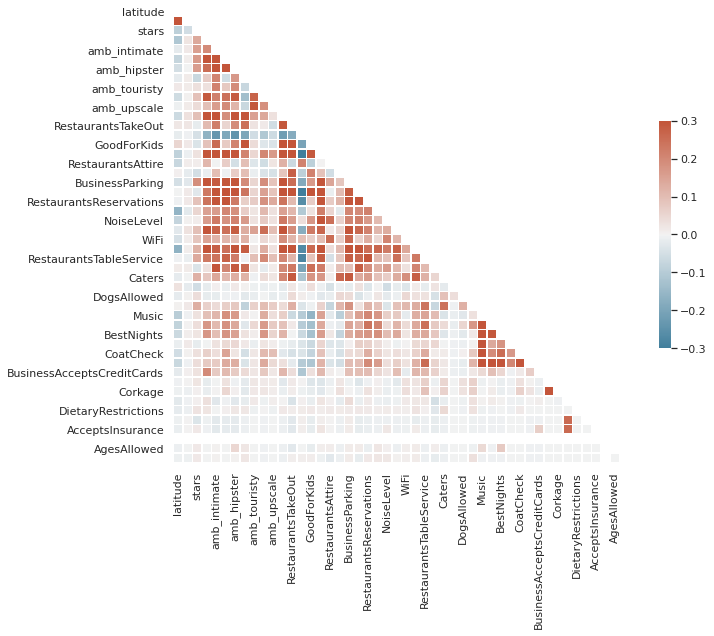

In [142]:
sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(res.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(res.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()


We try and plot a heatmap between the attributes to see which of these attributes will be use for modelling and predition.Apparently,RestaurantsTakeOut,GoodForKids,RestaurantsAttire,GoodForDancing,amb_intimate and amb_hipster and Smoking, seem important attributes,to keep in our dataset.

In [143]:
corr_matrix = res.corr()
#correlation matrix between the attributes
corr_avg_stars = corr_matrix['stars'].sort_values(ascending=False)
corr_avg_stars.pop('stars')

1.0

Text(0, 0.5, 'Corr')

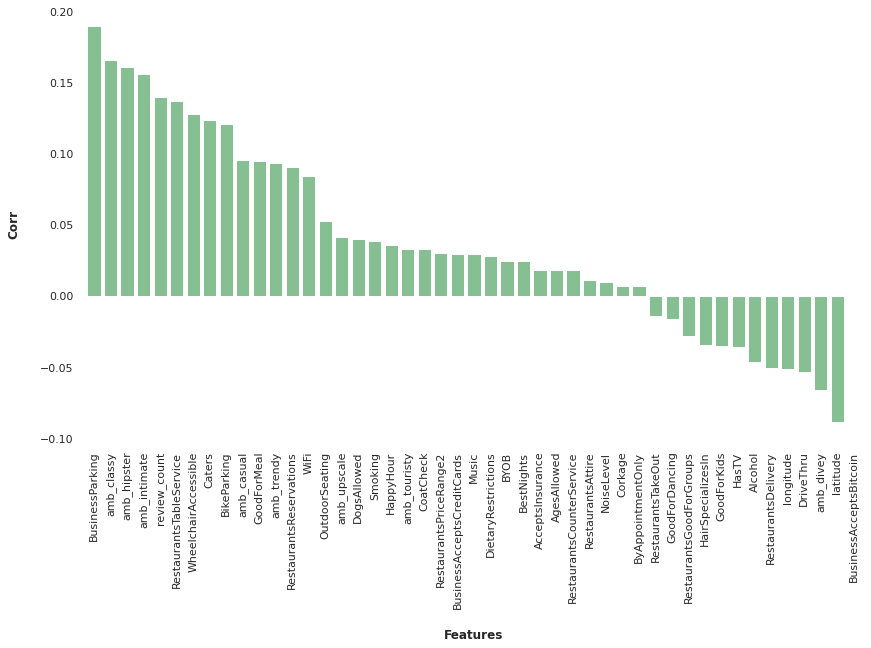

In [144]:
ax = corr_avg_stars.plot(kind='bar', sharex=False, figsize=(14,8), color = '#86bf91', zorder=2, width=0.8)

#despine
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Features', labelpad=20, weight='bold')
ax.set_ylabel('Corr', labelpad=20, weight='bold')


We further do a barplot for the correlations between the attribute features and stars and get a visualisation for the same.The first 10 seem to be quite important attributes that need to be in our dataset for feature Engineering purposes.

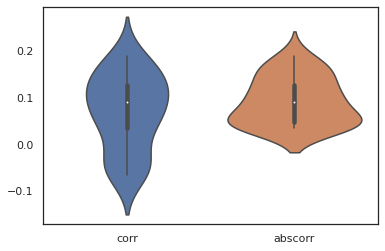

In [145]:
sns.violinplot(data=corr);

As we remember, the Tim Hortons, Mc Donalds and Subway had the highest number of outlets. Let's see what is the response of people based on their ratings for these businesses.

In [49]:
resp=res[res.name.isin(TopRes.index)][['business_id','name']]
resp.reset_index()

,index,business_id,name
0,1,8k62wYhDVq1-652YbJi5eg,Tim Hortons
1,33,AOhJfJVuEPUh_in7WHDnzQ,Subway
2,36,2vuAlukfUZf3vbHsexEeDw,McDonald's
3,38,kwXTdolA_0G2haHW4To5kA,Freshii
4,44,_o2fJBcVgLpy-L970Y7qYQ,Thai Express
...,...,...,...
516,5415,kqW_BKO3XCOx8ifbzQsnGA,McDonald's
517,5434,q9X0rwLBGehmRwXFqlWE-A,Aroma Espresso Bar
518,5442,vQXhuCQ4Wc3WWesp9hy3VQ,Pizza Hut
519,5447,undz-LtXIta312RP_DqmFQ,Subway


In [50]:
resp=pd.merge(resp,reviews,how='inner',on="business_id")

In [51]:
#resp.groupby("business_id")['stars'].mean()

#####Plotting for Tim Hortons:

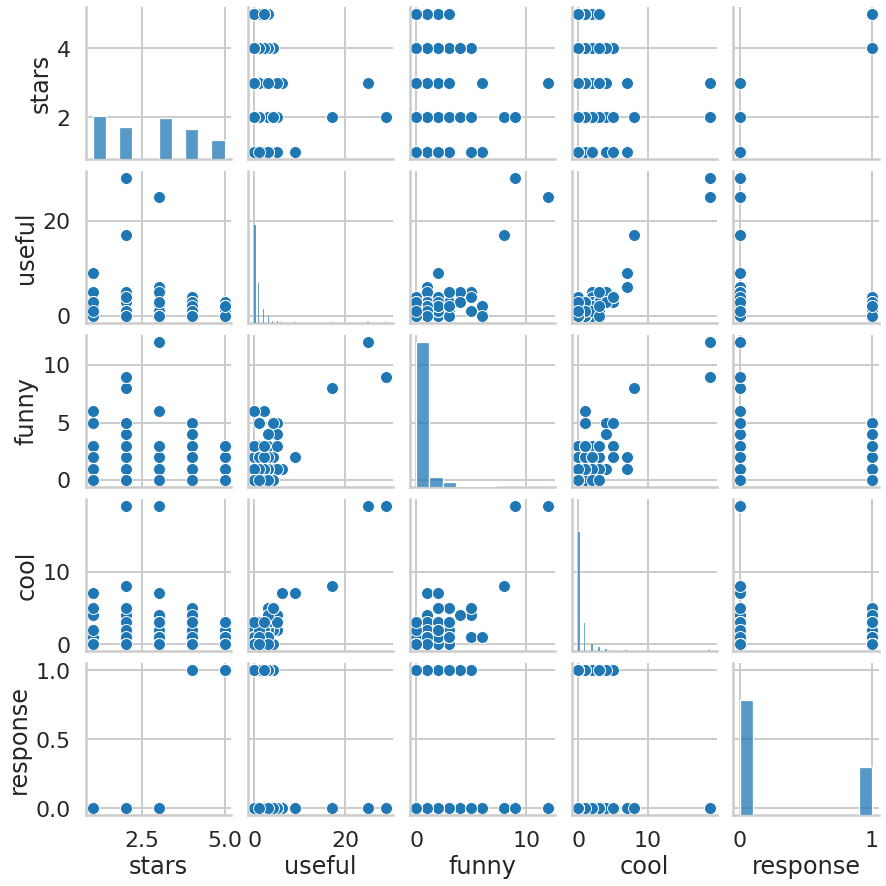

In [52]:
sns.pairplot(data=resp[resp.name=='Tim Hortons'])

We get a pairplot to see the correlations  between the various columns of the review dataset based on th Tim Hortons case and we see that users who have given funny reviews,seem to have also given greater number of ratings,compared to other.

####Plotting for Subways:

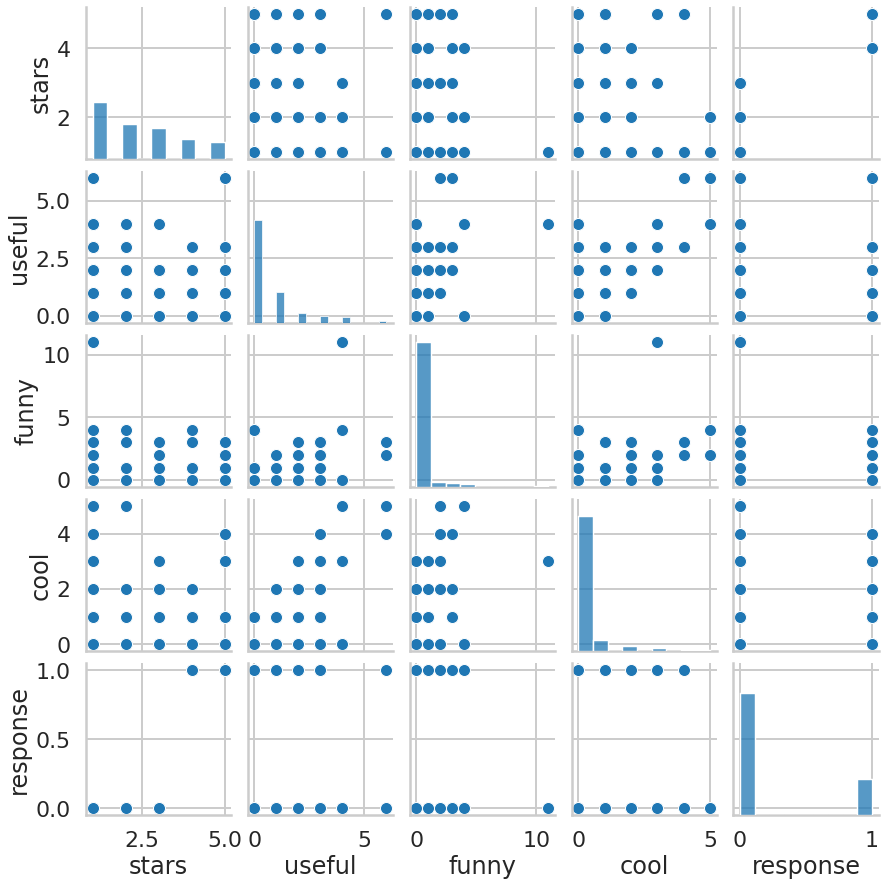

In [53]:
sns.pairplot(data=resp[resp.name=='Subway'])

In case of Subway, we see that, users with cool reviews seem to have given more number of ratings to the Subways.

####Plotting for both:

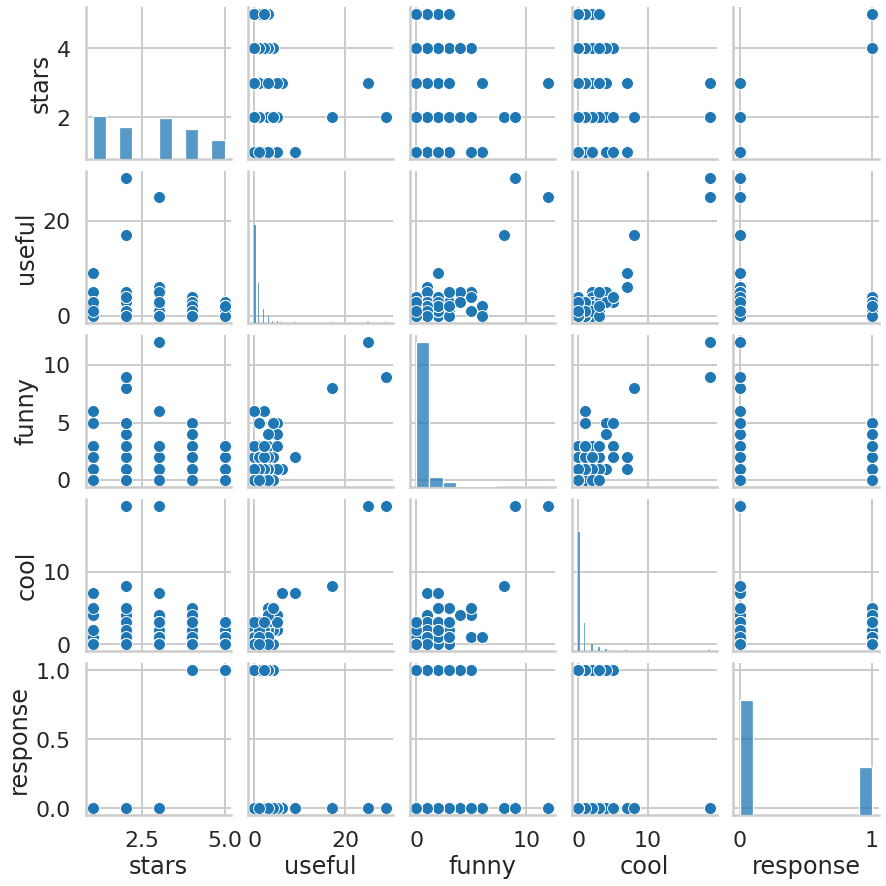

In [54]:
sns.pairplot(data=resp[resp.name.isin(['Tim Hortons','Subways'])])

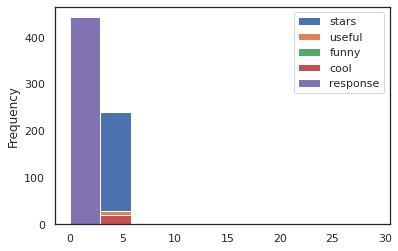

In [116]:
resp[resp.name.isin(['Tim Hortons','Subways'])].plot(kind='hist')

Both the Tim Hortons and Subway have obtained, good number of responses, a good number of ratings,very few useful but mostly cool reviews. These responses are majorly, because of the strong market hold of these businesses as stated and visualised earlier.

###Looking into the Users with the maximum number of reviews:

In [146]:
user=reviews.groupby('user_id').agg({'review_id':['count'],'stars':['mean']})

In [147]:
user=user.sort_values([('review_id','count')],ascending=False)

In [148]:
user.head(10)

,review_id,stars
,count,mean
user_id,,
858,718,3.345404
402,451,4.024390
694,435,3.358621
1745,401,3.496259
4047,394,3.401015
2252,333,3.093093
1002,306,3.019608
348,281,3.960854


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


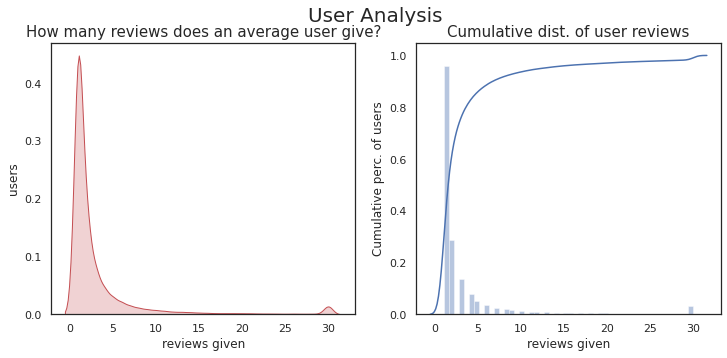

In [149]:
user[('review_id','count')].loc[user[('review_id','count')]>30] = 30
plt.figure(figsize=(12,5))
plt.suptitle("User Analysis",fontsize=20)

plt.subplot2grid((1,2),(0,0))
#Cumulative Distribution
ax=sns.kdeplot(user[('review_id','count')],shade=True,color='r')
plt.title("How many reviews does an average user give?",fontsize=15)
plt.xlabel('reviews given', fontsize=12)
plt.ylabel('users', fontsize=12)

#Cumulative Distribution
plt.subplot2grid((1,2),(0,1))
sns.distplot(user[('review_id','count')],
             kde_kws=dict(cumulative=True))
plt.title("Cumulative dist. of user reviews",fontsize=15)
plt.ylabel('Cumulative perc. of users', fontsize=12)
plt.xlabel('reviews given', fontsize=12)

plt.show();


#Collaborative Filtering:


We have two datasets. One is for the businesses:'res' dataset and one for the users :'reviews'.We use these two to make our baseline model. First, without any residual factors and 2. With residual Factors.

In [150]:
res.to_pickle('restaurant_df')

In [151]:
res.columns

Index(['business_id', 'name', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories', 'amb_romantic', 'amb_intimate', 'amb_classy', 'amb_hipster', 'amb_divey', 'amb_touristy', 'amb_trendy', 'amb_upscale', 'amb_casual', 'RestaurantsTakeOut', 'Alcohol', 'GoodForKids', 'RestaurantsPriceRange2', 'RestaurantsAttire', 'RestaurantsDelivery', 'BusinessParking', 'RestaurantsGoodForGroups', 'RestaurantsReservations', 'OutdoorSeating', 'NoiseLevel', 'GoodForMeal', 'WiFi', 'BikeParking', 'RestaurantsTableService', 'HasTV', 'Caters', 'DriveThru', 'DogsAllowed', 'WheelchairAccessible', 'Music', 'HappyHour', 'BestNights', 'GoodForDancing', 'CoatCheck', 'Smoking', 'BusinessAcceptsCreditCards', 'BYOB', 'Corkage', 'ByAppointmentOnly', 'DietaryRestrictions', 'HairSpecializesIn', 'AcceptsInsurance', 'BusinessAcceptsBitcoin', 'AgesAllowed', 'RestaurantsCounterService'], dtype='object')

In [152]:
res=res[['business_id', 'name','stars', 'review_count', 'categories','amb_romantic', 'amb_intimate', 'amb_classy', 'amb_hipster', 'amb_divey', 'amb_touristy', 'amb_trendy', 'amb_upscale', 'amb_casual','RestaurantsTakeOut', 'Alcohol', 'GoodForKids', 'RestaurantsPriceRange2', 'RestaurantsAttire', 'RestaurantsDelivery', 'BusinessParking','GoodForMeal','GoodForDancing', 'CoatCheck', 'Smoking']]

In [169]:
res.head()

,name,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,GoodForMeal,GoodForDancing,CoatCheck,Smoking
id,,,,,,,,,,,,,,,,,,,,,,,,
0,Mi Mi Restaurant,4.0,116,"Vietnamese, Restaurants",False,0,0,0,0,0,0,0,2,1,4,2,1,4,0,1,24,0,0,0
1,Tim Hortons,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,0,0,0,-1,0,0,0,0,1,2,2,1,0,0,0,0,0,0,0
2,Chick-N-Joy,3.0,11,"Fast Food, Restaurants, Chicken Shop",False,0,0,0,-1,0,0,0,0,1,2,2,2,4,2,0,3,0,0,0
3,Zav Coffee Shop & Gallery,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",NaN,-1,-1,-1,-1,0,0,0,0,1,6,0,1,3,0,0,0,0,0,0
4,The Keg Steakhouse + Bar,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",False,0,2,0,0,0,0,0,0,1,5,2,3,4,0,0,8,0,0,0


In [154]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,response
25,mM8i91yWP1QbImEvz5ds0w,0,495,4.0,0,0,0,1
44,nAm92_-WUQ084x9Uz9iFmA,1,301,3.0,0,0,0,0
114,V3kZd0O3EeVuTBCKOW-M4g,2,103,5.0,2,0,0,1
134,Lx-ervsT1BqUL7OfW-Lb9A,3,284,5.0,0,0,0,1
148,saJUbTtnictm8KFx6cNNJA,4,154,5.0,0,0,2,1


Considering only the reviews of restaurants in Toronto:


In [155]:
business=res.business_id.unique()
reviews=reviews[reviews.business_id.isin(business)]



In [166]:
reviews.to_pickle("revTor")
reviews=pd.read_pickle('revTor')

In [167]:
reviews.reset_index()

,index,review_id,user_id,business_id,stars,useful,funny,cool,response
0,25,mM8i91yWP1QbImEvz5ds0w,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4.0,0,0,0,1
1,44,nAm92_-WUQ084x9Uz9iFmA,iFEM16O5BeKvf_AHs6NzUQ,9Eghhu_LzEJgDKNgisf3rg,3.0,0,0,0,0
2,114,V3kZd0O3EeVuTBCKOW-M4g,Eg_VTAQwK3CxYTORNRWd2g,4m_hApwQ054v3ue_OxFmGw,5.0,2,0,0,1
3,134,Lx-ervsT1BqUL7OfW-Lb9A,IIE2OX5haarGNefY23R8BA,jM6JjZXFAQQANwdlEwbH3g,5.0,0,0,0,1
4,148,saJUbTtnictm8KFx6cNNJA,RRhco4irDXPk5EJmvuwr2w,PMPMHHLe9vFzcR67iCjgLA,5.0,0,0,2,1
...,...,...,...,...,...,...,...,...,...
338323,8020622,9lEYzla0NLZyMsNV-b53Qg,E1hLHq6LZ6AoSJzW-oT4FQ,xF2zrVbXtB6TxMBPGJKxog,2.0,3,0,1,0
338324,8020639,rBfr17beQCItyFrqdxOFEw,O8kmR1np3bcF_--U1vDkYA,5_2Lls-h_shbRGyUruLlTQ,5.0,2,0,0,1
338325,8020643,X9a03IeCFtSeI1fOaicE2g,6ORiBNRD1FpaIJv3yLRZ4Q,9tfw-OEfpF0qC2hSzRks6g,5.0,1,1,1,1
338326,8020780,2By_gXjZCbiEE1ZTO6hDcQ,sYl1niCXXzFbyI4UPouM3w,aFQQMQlUIW9KajS6oH5kyw,4.0,2,4,4,1


In [171]:
restaurant = res.business_id.unique()
user = reviews.user_id.unique()

In [172]:
userid2idx = {o:i for i,o in enumerate(user)}
resid2idx = {o:i for i,o in enumerate(restaurant)}

In [175]:
reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'response'], dtype='object')

In [176]:
reviews['business_id'] = reviews.business_id.apply(lambda x: resid2idx[x])
reviews['user_id'] = reviews.user_id.apply(lambda x: userid2idx[x])


res = res[res.business_id.isin(restaurant)]
res['id'] = res.business_id.apply(lambda x: resid2idx[x])
res.head()

KeyError: ignored

In [161]:
res = res.drop('business_id', axis=1).set_index('id')
res.head() #completed the transformation

,name,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,GoodForMeal,GoodForDancing,CoatCheck,Smoking
id,,,,,,,,,,,,,,,,,,,,,,,,
0,Mi Mi Restaurant,4.0,116,"Vietnamese, Restaurants",False,0,0,0,0,0,0,0,2,1,4,2,1,4,0,1,24,0,0,0
1,Tim Hortons,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,0,0,0,-1,0,0,0,0,1,2,2,1,0,0,0,0,0,0,0
2,Chick-N-Joy,3.0,11,"Fast Food, Restaurants, Chicken Shop",False,0,0,0,-1,0,0,0,0,1,2,2,2,4,2,0,3,0,0,0
3,Zav Coffee Shop & Gallery,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",NaN,-1,-1,-1,-1,0,0,0,0,1,6,0,1,3,0,0,0,0,0,0
4,The Keg Steakhouse + Bar,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",False,0,2,0,0,0,0,0,0,1,5,2,3,4,0,0,8,0,0,0


In [162]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,response


In [70]:
restaurant_names = res.name.to_dict() #trasnformed key:movie name
restaurant_names

{0: 'Mi Mi Restaurant',
 1: 'Tim Hortons',
 2: 'Chick-N-Joy',
 3: 'Zav Coffee Shop & Gallery',
 4: 'The Keg Steakhouse + Bar',
 5: 'Fearless Meat',
 6: 'St. Louis Bar & Grill',
 7: "Mi'Hito Sushi Laboratory",
 8: 'Edulis',
 9: 'Spiga Ristorante',
 10: 'Martins',
 11: 'Bistro Grande',
 12: 'Veghed',
 13: 'Kinoya Sushi Bar',
 14: 'Skippa',
 15: 'Chopin Restaurant',
 16: 'Xe Lua Restaurant',
 17: 'My Roti Place',
 18: 'Plentea',
 19: 'Anoush Shawarma',
 20: 'Akira Back',
 21: 'Heart Clean Eats',
 22: "Better than Yia Yia's",
 23: 'Best Bite Bar & Grill',
 24: 'Chicken Monster',
 25: 'Baby Point Lounge',
 26: 'Pizza Cafe',
 27: 'Pagoda',
 28: 'DeCourses Café',
 29: 'Bar Centrale',
 30: 'Mezbaan Food',
 31: '00 Gelato',
 32: 'Chinese Egg Waffle Vendor',
 33: 'Subway',
 34: 'Burrito Boyz',
 35: 'Korean Grill House',
 36: "McDonald's",
 37: 'Mercado Negro',
 38: 'Freshii',
 39: 'Dessert Lady Café',
 40: 'Kay Pacha',
 41: 'The Fish Store & Sandwiches',
 42: 'Sugar Marmalade',
 43: 'The Carlton

In [71]:
reviews.to_csv("ratings_contig.csv", index=False)
res.to_csv("restaurants_contig.csv", index=False)

In [72]:
nusers = reviews.user_id.nunique()
nresto = reviews.business_id.nunique()
nusers, nresto

(90665, 5462)

###Setting up Baseline Model:


In [73]:
np.random.seed=2017
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(range(reviews.shape[0]), train_size=0.8)
trdf = reviews.iloc[train_indices]
valdf = reviews.iloc[val_indices]
trdf.shape, valdf.shape

((270662, 8), (67666, 8))

In [74]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [77]:
L=40
REG=5e-4

In [76]:
def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

In [78]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [79]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
res_input, rLmat = embedding_input('res_input', nresto, L, REG)

In [81]:
uLmat.shape, rLmat.shape

(TensorShape([None, 1, 40]), TensorShape([None, 1, 40]))

In [82]:
user_bias = create_bias('user_bias', user_input, nusers, REG)
res_bias = create_bias('res_bias', res_input, nresto, REG)

In [84]:
residual = Dot(axes=2, name="residual")([uLmat, rLmat])

In [85]:
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

In [92]:
regression = Add(name="regression")([user_bias, res_bias,residflat])

In [93]:
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

In [88]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low #within range
    return custom_sigmoid
cs = sigmoid_maker(0, 5.5)

In [94]:
output = Activation(cs, name="Sigmoid_Range")(regression)

In [95]:
model = Model([user_input, res_input], output)
model.compile(Adam(0.001), loss='mse')

In [96]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
res_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 40)        3626600     user_input[0][0]                 
__________________________________________________________________________________________________
res_factor (Embedding)          (None, 1, 40)        218480      res_input[0][0]                  
____________________________________________________________________________________________

In [99]:
model.optimizer.lr=0.001
model.fit([trdf.user_id, trdf.business_id], trdf.stars,
 batch_size=64,
 epochs=4,
 validation_data=([valdf.user_id, valdf.business_id],
 valdf.stars))

Epoch 1/4
4230/4230 [==============================] - 160s 38ms/step - loss: 2.1811 - val_loss: 1.6050
Epoch 2/4
4230/4230 [==============================] - 156s 37ms/step - loss: 1.4947 - val_loss: 1.4288
Epoch 3/4
4230/4230 [==============================] - 156s 37ms/step - loss: 1.3034 - val_loss: 1.3698
Epoch 4/4
4230/4230 [==============================] - 160s 38ms/step - loss: 1.2141 - val_loss: 1.3443


In [100]:
model.optimizer.lr=0.01
model.fit([trdf.user_id, trdf.business_id], trdf.stars,
 batch_size=64,
 epochs=4,
 validation_data=([valdf.user_id, valdf.business_id],
 valdf.stars))

Epoch 1/4
4230/4230 [==============================] - 157s 37ms/step - loss: 1.2603 - val_loss: 1.3910
Epoch 2/4
4230/4230 [==============================] - 157s 37ms/step - loss: 1.0620 - val_loss: 1.4350
Epoch 3/4
4230/4230 [==============================] - 159s 38ms/step - loss: 0.9634 - val_loss: 1.4792
Epoch 4/4
4230/4230 [==============================] - 160s 38ms/step - loss: 0.9102 - val_loss: 1.5070


In [102]:
model.optimizer.lr=0.01
model.fit([trdf.user_id, trdf.business_id], trdf.stars,
 batch_size=64,
 epochs=6,
 validation_data=([valdf.user_id, valdf.business_id],
 valdf.stars))

Epoch 1/6
4230/4230 [==============================] - 159s 38ms/step - loss: 1.4299 - val_loss: 1.7077
Epoch 2/6
4230/4230 [==============================] - 160s 38ms/step - loss: 1.0312 - val_loss: 1.6256
Epoch 3/6
4230/4230 [==============================] - 160s 38ms/step - loss: 0.9437 - val_loss: 1.5932
Epoch 4/6
4230/4230 [==============================] - 158s 37ms/step - loss: 0.9071 - val_loss: 1.5828
Epoch 5/6
4230/4230 [==============================] - 159s 38ms/step - loss: 0.8880 - val_loss: 1.5734
Epoch 6/6
4230/4230 [==============================] - 159s 38ms/step - loss: 0.8767 - val_loss: 1.5781


In [106]:
dfpreds = reviews[['business_id', 'stars', 'user_id']].copy()
dfpreds['predictions'] = model.predict([dfpreds.user_id, dfpreds.business_id]).ravel()

Text(0, 0.5, 'prediction')

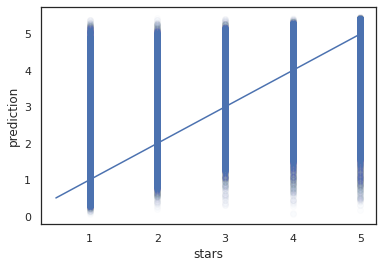

In [107]:
plt.scatter(dfpreds.stars, dfpreds.predictions, alpha=0.01)
plt.plot([0.5,5],[0.5,5])
plt.xlabel("stars")
plt.ylabel("prediction")

In [108]:
preds_stats=dfpreds.groupby('stars')['predictions'].describe().reset_index()
preds_stats

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,32329.0,2.161591,1.168429,0.048093,1.091822,1.985878,3.122546,5.390643
1,2.0,32204.0,2.946517,0.867337,0.209518,2.274274,2.971540,3.585908,5.438310
2,3.0,57906.0,3.429153,0.676269,0.307240,2.999839,3.445827,3.899076,5.417673
3,4.0,108510.0,3.849570,0.607624,0.062442,3.507834,3.915145,4.260638,5.447209
4,5.0,107379.0,4.397728,0.685172,0.170058,4.017809,4.555565,4.940273,5.473698


In [109]:
preds_stats_train = dfpreds.iloc[train_indices].groupby('stars')['predictions'].describe().reset_index()
preds_stats_train

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,25938.0,1.952280,1.087554,0.048093,1.026856,1.598811,2.815959,5.243372
1,2.0,25839.0,2.863145,0.837869,0.330161,2.198038,2.870608,3.493346,5.312183
2,3.0,46116.0,3.409188,0.650737,0.307240,2.988139,3.419456,3.864289,5.273015
3,4.0,86877.0,3.866771,0.569527,0.549539,3.541139,3.926154,4.255166,5.371192
4,5.0,85892.0,4.489830,0.615906,0.375861,4.143856,4.658014,4.970237,5.473698


Text(0, 0.5, 'prediction')

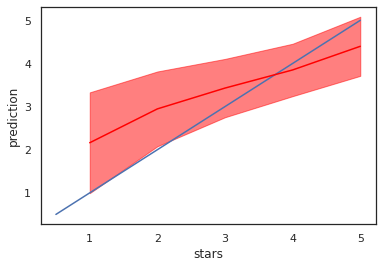

In [110]:
preds_stats_val = dfpreds.iloc[val_indices].groupby('stars')['predictions'].describe().reset_index()
preds_stats_val
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats.stars, preds_stats['mean'], color="red")
plt.fill_between(preds_stats.stars, preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")

Text(0.5, 1.0, 'train')

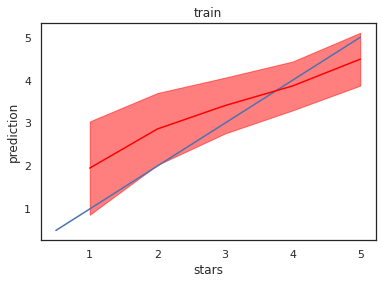

In [111]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_train.stars, preds_stats_train['mean'], color="red")
plt.fill_between(preds_stats_train.stars, preds_stats_train['mean']-preds_stats_train['std'], preds_stats_train['mean']+preds_stats_train['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")
plt.title('train')


Text(0.5, 1.0, 'val')

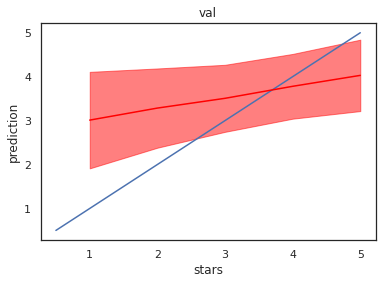

In [112]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_val.stars, preds_stats_val['mean'], color="red")
plt.fill_between(preds_stats_val.stars, preds_stats_val['mean']-preds_stats_val['std'], preds_stats_val['mean']+preds_stats_val['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")
plt.title('val')